In [ ]:
pip install -q google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.3/113.3 kB 5.7 MB/s eta 0:00:00


In [ ]:
# import google.generativeai as palm

import re
import tqdm
import keras
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import ast
from keras import layers,regularizers
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_20newsgroups
import sklearn.metrics as skmetrics
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Datasets/Train_Dataset_With_Embeddings.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Datasets/Test_Dataset_With_Embeddings.csv')

In [ ]:
train_df['Embeddings']  = train_df['Embeddings'].apply(ast.literal_eval)
train_df['Embeddings_GPT']  = train_df['Embeddings_GPT'].apply(ast.literal_eval)
train_df['Embeddings_Bert']  = train_df['Embeddings_Bert'].apply(ast.literal_eval)


In [ ]:
test_df['Embeddings']  = test_df['Embeddings'].apply(ast.literal_eval)
test_df['Embeddings_GPT']  = test_df['Embeddings_GPT'].apply(ast.literal_eval)
test_df['Embeddings_Bert']  = test_df['Embeddings_Bert'].apply(ast.literal_eval)

In [ ]:
def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
  inputs = x = keras.Input(input_size)
  x = layers.Dense(input_size, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(num_classes, activation='sigmoid')(x)
  return keras.Model(inputs=[inputs], outputs=x)


# PaLM

In [ ]:
# Derive the embedding size from the first training element.
embedding_size = len(train_df['Embeddings'].iloc[0])

# Give your model a different name, as you have already used the variable name 'model'
classifier = build_classification_model(embedding_size, len(train_df['label'].unique()))
classifier.summary()

classifier.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   optimizer = keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 768)               590592    
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 3076      
                                                                 
Total params: 593,668
Trainable params: 593,668
Non-trainable params: 0
_________________________________________________________________


In [ ]:
embedding_size

768

In [ ]:
NUM_EPOCHS = 50
BATCH_SIZE = 32

# Split the x and y components of the train and validation subsets.
y_train = train_df['label']
x_train = np.stack(train_df['Embeddings'])
y_val = test_df['label']
x_val = np.stack(test_df['Embeddings'])

# Train the model for the desired number +of epochs.
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
# callbacks=[callback],
history = classifier.fit(x=x_train,
                         y=y_train,
                         validation_data=(x_val, y_val),
                         callbacks=[callback],
                         batch_size=BATCH_SIZE,
                         epochs=NUM_EPOCHS,)

Epoch 1/50
3750/3750 [==============================] - 10s 2ms/step - loss: 0.3201 - accuracy: 0.8915 - val_loss: 0.2932 - val_accuracy: 0.8980
Epoch 2/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2773 - accuracy: 0.9035 - val_loss: 0.2870 - val_accuracy: 0.9003
Epoch 3/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2609 - accuracy: 0.9091 - val_loss: 0.2739 - val_accuracy: 0.9039
Epoch 4/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2471 - accuracy: 0.9139 - val_loss: 0.2651 - val_accuracy: 0.9067
Epoch 5/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2334 - accuracy: 0.9184 - val_loss: 0.2618 - val_accuracy: 0.9104
Epoch 6/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2208 - accuracy: 0.9228 - val_loss: 0.2575 - val_accuracy: 0.9129
Epoch 7/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2097 - accuracy: 0.9265 - val_loss: 0.2520 - val_accuracy

In [ ]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

238/238 [==============================] - 0s 1ms/step - loss: 0.4926 - accuracy: 0.9143


{'loss': 0.4926375448703766, 'accuracy': 0.9143421053886414}

In [ ]:
y_hat = classifier.predict(x=x_val)
y_hat = np.argmax(y_hat, axis=1)

238/238 [==============================] - 0s 1ms/step


In [ ]:
import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_val, y_hat)
print('Accuracy:', accuracy*100)

Accuracy: 91.43421052631578


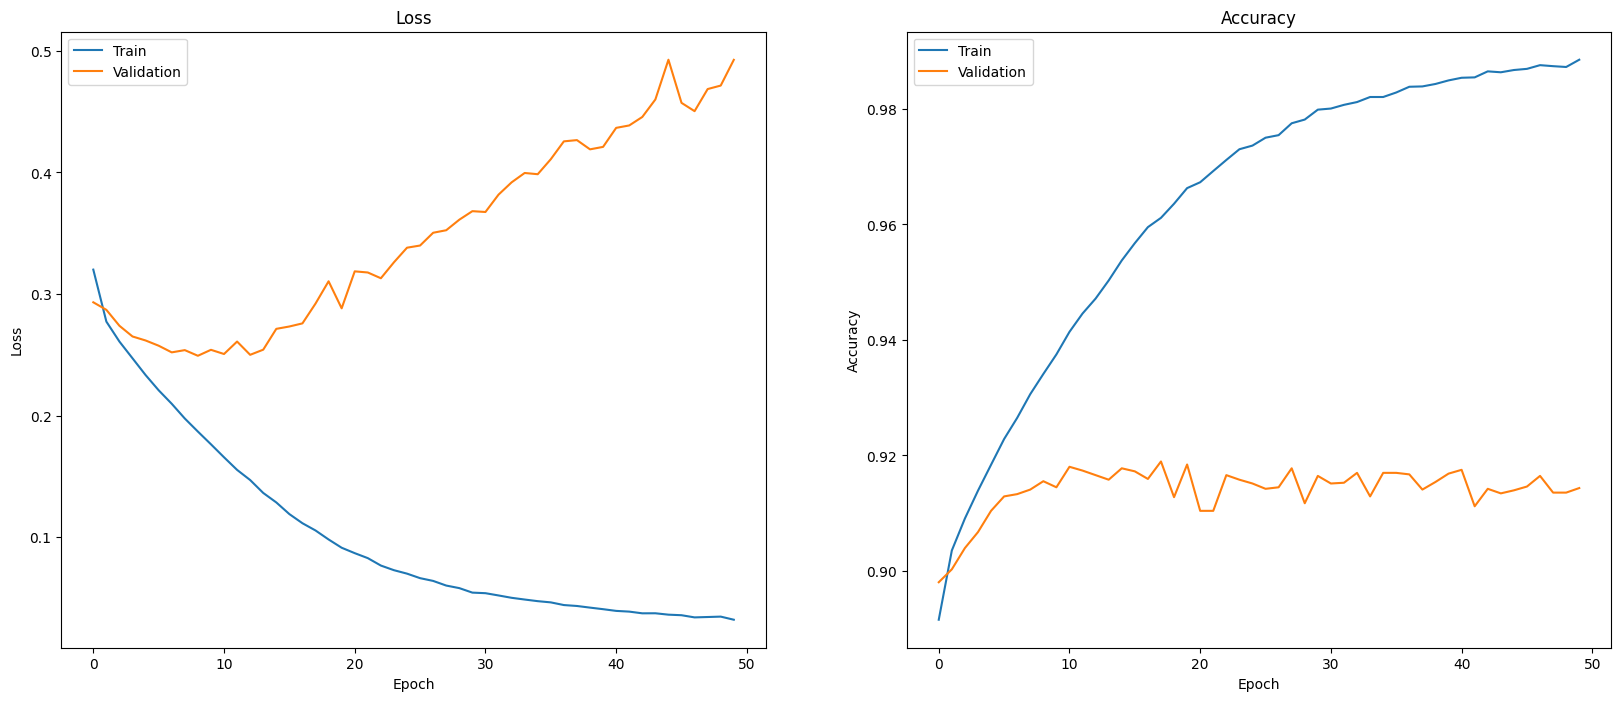

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [ ]:
labels_dict = {'World':0, 'Sports':1, 'Business':2, 'Sci/Tech':3}

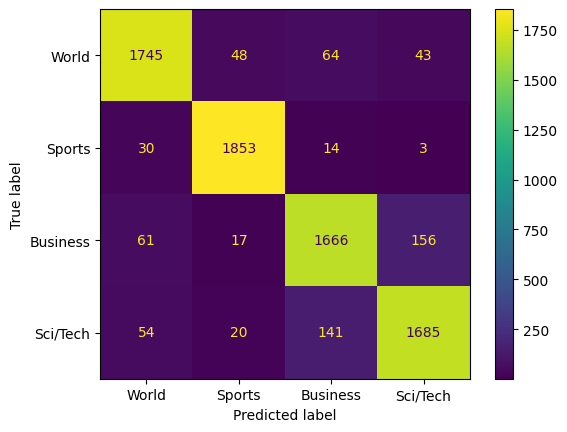

In [ ]:
cm = skmetrics.confusion_matrix(y_val, y_hat)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_dict.keys())
disp.plot(xticks_rotation='horizontal')

plt.grid(False)

# GPT

In [ ]:
# Derive the embedding size from the first training element.
embedding_size = len(train_df['Embeddings_GPT'].iloc[0])

# Give your model a different name, as you have already used the variable name 'model'
classifier = build_classification_model(embedding_size, len(train_df['label'].unique()))
classifier.summary()

classifier.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   optimizer = keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_2 (Dense)             (None, 768)               590592    
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 3076      
                                                                 
Total params: 593,668
Trainable params: 593,668
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 50
BATCH_SIZE = 32
import numpy as np
# Split the x and y components of the train and validation subsets.
y_train = train_df['label']
x_train = np.stack(train_df['Embeddings_GPT'])
y_val = test_df['label']
x_val = np.stack(test_df['Embeddings_GPT'])

# Train the model for the desired number of epochs.
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

history = classifier.fit(x=x_train,
                         y=y_train,
                         validation_data=(x_val, y_val),
                         callbacks=[callback],
                         batch_size=BATCH_SIZE,
                         epochs=NUM_EPOCHS,)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3750/3750 [==============================] - 10s 2ms/step - loss: 0.5100 - accuracy: 0.8279 - val_loss: 0.4272 - val_accuracy: 0.8454
Epoch 2/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.3993 - accuracy: 0.8560 - val_loss: 0.4042 - val_accuracy: 0.8551
Epoch 3/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.3802 - accuracy: 0.8633 - val_loss: 0.3752 - val_accuracy: 0.8642
Epoch 4/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.3689 - accuracy: 0.8680 - val_loss: 0.3589 - val_accuracy: 0.8707
Epoch 5/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.3590 - accuracy: 0.8712 - val_loss: 0.3844 - val_accuracy: 0.8586
Epoch 6/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.3504 - accuracy: 0.8734 - val_loss: 0.3468 - val_accuracy: 0.8758
Epoch 7/50
3750/3750 [==============================] - 9s 2ms/step - loss: 0.3440 - accuracy: 0.8761 - val_loss: 0.3656 - val_accuracy: 0.8674
Ep

In [ ]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

238/238 [==============================] - 0s 2ms/step - loss: 0.3204 - accuracy: 0.8911


{'loss': 0.32039251923561096, 'accuracy': 0.8910526037216187}

In [ ]:
y_hat = classifier.predict(x=x_val)
y_hat = np.argmax(y_hat, axis=1)

238/238 [==============================] - 0s 1ms/step


In [ ]:
accuracy = metrics.accuracy_score(y_val, y_hat)
print('Accuracy:', accuracy*100)

Accuracy: 89.10526315789473


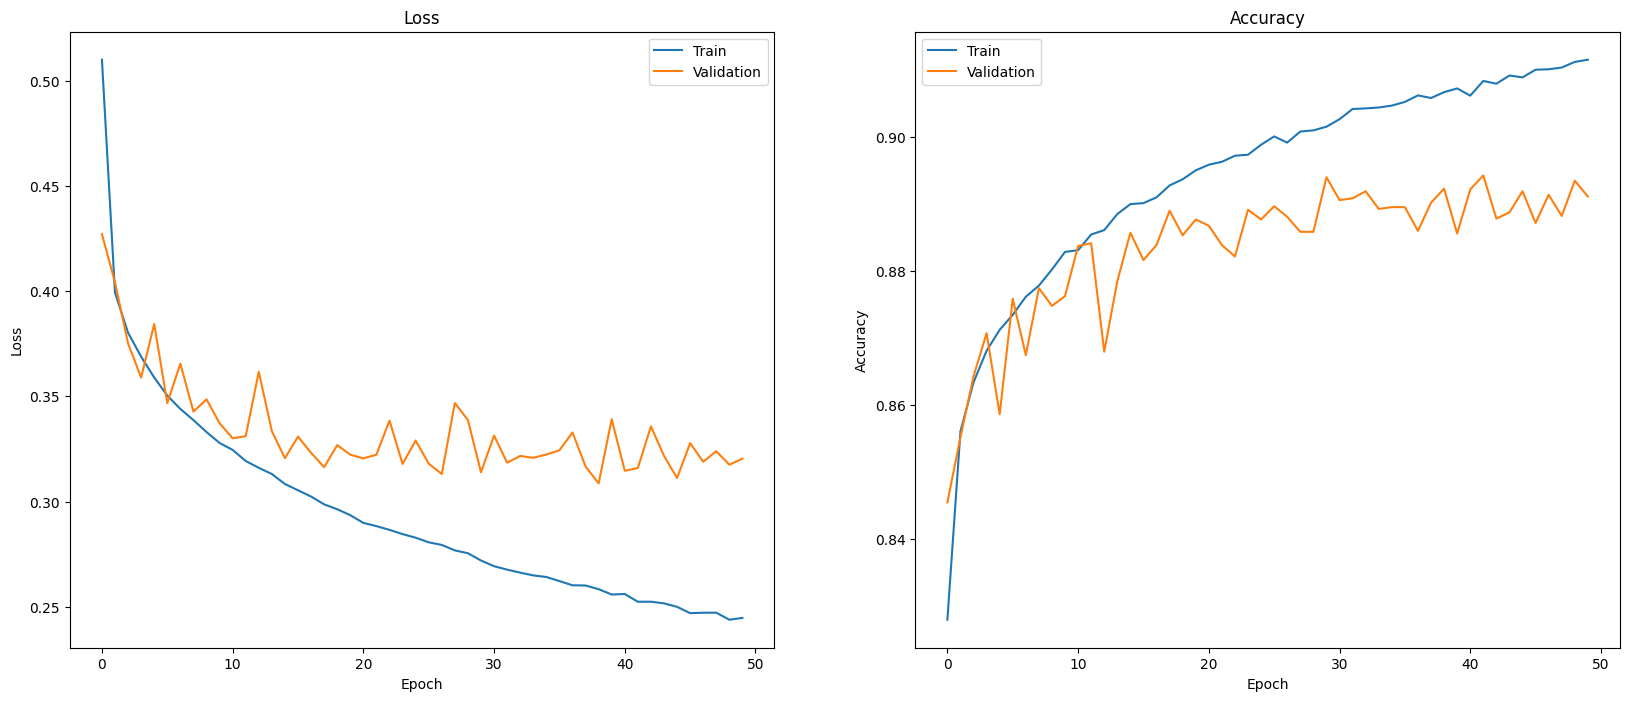

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

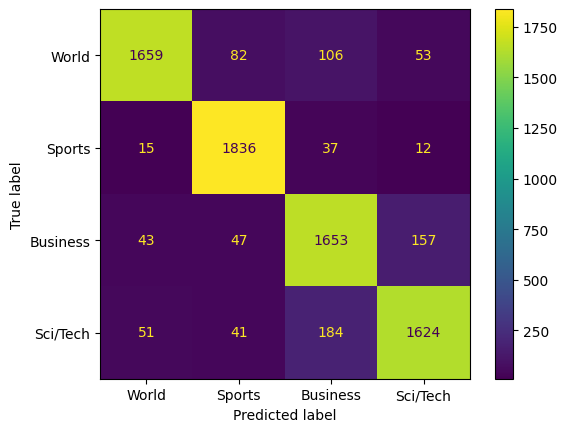

In [ ]:
cm = skmetrics.confusion_matrix(y_val, y_hat)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_dict.keys())
disp.plot(xticks_rotation='horizontal')
#plt.title('Confusion matrix for newsgroup test dataset');
plt.grid(False)

# BERT

In [ ]:
# Derive the embedding size from the first training element.
embedding_size = len(train_df['Embeddings_Bert'].iloc[0])

# Give your model a different name, as you have already used the variable name 'model'
classifier = build_classification_model(embedding_size, len(train_df['label'].unique()))
classifier.summary()

classifier.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   optimizer = keras.optimizers.Adam(learning_rate=0.0001),
                   metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_8 (Dense)             (None, 768)               590592    
                                                                 
 dropout_4 (Dropout)         (None, 768)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 3076      
                                                                 
Total params: 593,668
Trainable params: 593,668
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 50
BATCH_SIZE = 64
import numpy as np
# Split the x and y components of the train and validation subsets.
y_train = train_df['label']
x_train = np.stack(train_df['Embeddings_Bert'])
y_val = test_df['label']
x_val = np.stack(test_df['Embeddings_Bert'])

# Train the model for the desired number of epochs.
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history = classifier.fit(x=x_train,
                         y=y_train,
                         validation_data=(x_val, y_val),
                         callbacks=[callback],
                         batch_size=BATCH_SIZE,
                         epochs=NUM_EPOCHS,)

Epoch 1/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6495 - accuracy: 0.7662 - val_loss: 0.5075 - val_accuracy: 0.8171
Epoch 2/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4728 - accuracy: 0.8314 - val_loss: 0.4472 - val_accuracy: 0.8449
Epoch 3/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4441 - accuracy: 0.8404 - val_loss: 0.4264 - val_accuracy: 0.8467
Epoch 4/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4279 - accuracy: 0.8463 - val_loss: 0.4102 - val_accuracy: 0.8508
Epoch 5/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4178 - accuracy: 0.8497 - val_loss: 0.4442 - val_accuracy: 0.8368
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4084 - accuracy: 0.8525 - val_loss: 0.4015 - val_accuracy: 0.8537
Epoch 7/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4026 - accuracy: 0.8553 - val_loss: 0.4178 - val_accuracy:

In [ ]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

238/238 [==============================] - 0s 1ms/step - loss: 0.3645 - accuracy: 0.8712


{'loss': 0.364452600479126, 'accuracy': 0.871184229850769}

In [ ]:
y_hat = classifier.predict(x=x_val)
y_hat = np.argmax(y_hat, axis=1)

238/238 [==============================] - 0s 1ms/step


In [ ]:
accuracy = metrics.accuracy_score(y_val, y_hat)
print('Accuracy:', accuracy*100)

Accuracy: 87.11842105263158


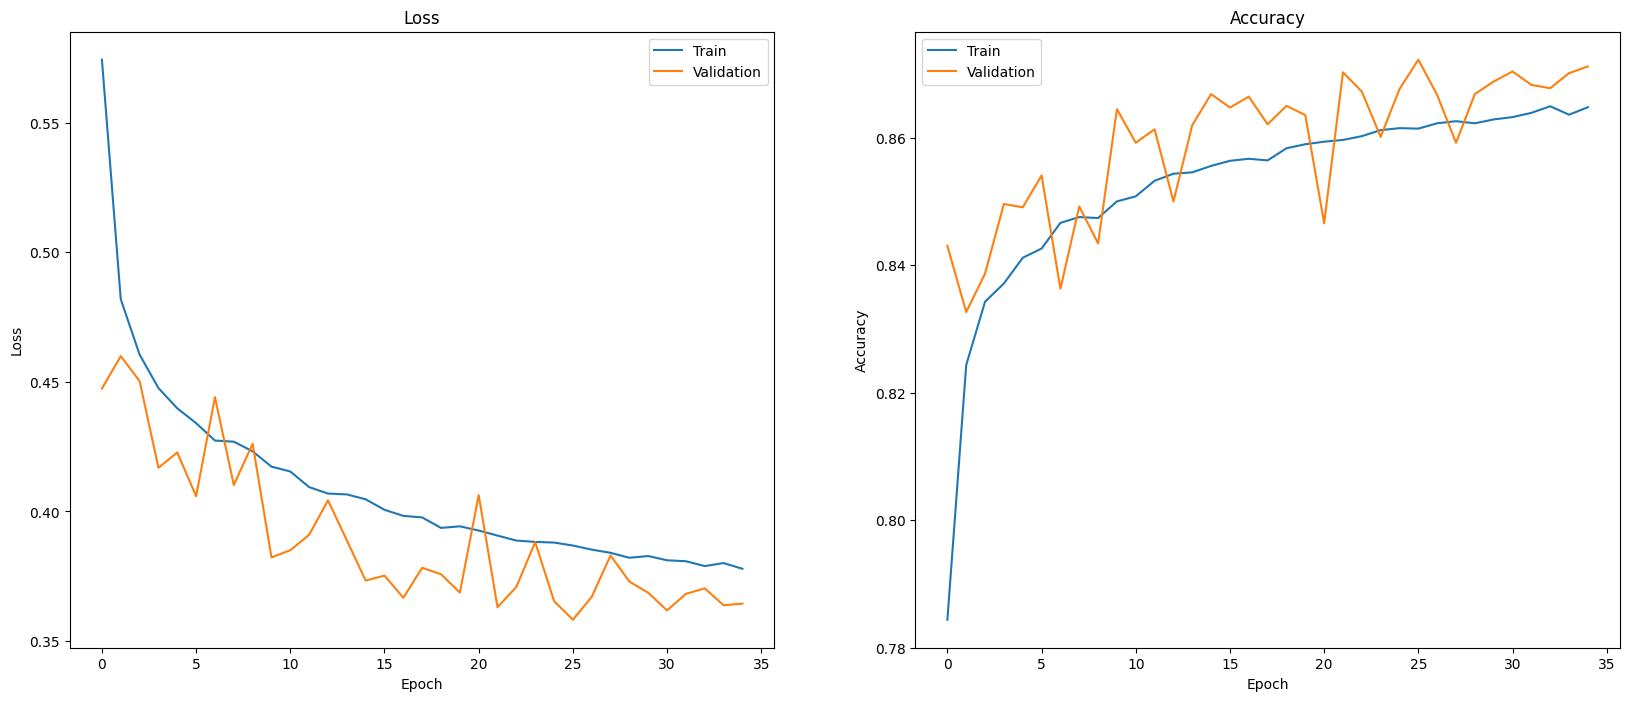

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

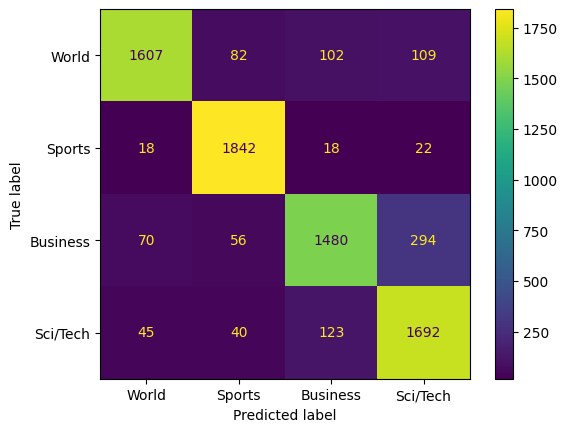

In [ ]:
cm = skmetrics.confusion_matrix(y_val, y_hat)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_dict.keys())
disp.plot(xticks_rotation='horizontal')
#plt.title('Confusion matrix for newsgroup test dataset');
plt.grid(False)